In [3]:
# libraries
import sys
sys.path.append("../models/")
from vaccine_behaviour import integrate_BV
from functions import import_country, get_totR, update_contacts
import pandas as pd 
import numpy as np 
import os 
from datetime import datetime, timedelta

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# epi params
eps   = 1.0 / 3.7
mu    = 1.0 / 2.5
omega = 1.0 / 1.5
chi   = 0.55
f     = 0.35 
IFR   = [0.00161 / 100, # 0-4  
         0.00161 / 100, # 5-9
         0.00695 / 100, # 10-14
         0.00695 / 100, # 15-19 
         0.0309  / 100, # 20-24 
         0.0309  / 100, # 25-29
         0.0844  / 100, # 30-34
         0.0844  / 100, # 35-39
         0.161   / 100, # 40-44 
         0.161   / 100, # 45-49 
         0.595   / 100, # 50-54 
         0.595   / 100, # 55-59 
         1.93    / 100, # 60-64
         1.93    / 100, # 65-69 
         4.28    / 100, # 70-74 
         6.04    / 100] # 75+
R0      = 1.15
Delta   = 17
i0      = 0.5 / 100.0
r0      = 10.0 / 100.0

# dates
start_date = datetime(2021, 1, 1)
end_date   = datetime(2021, 12, 1)

alpha      = 1
gamma      = 0.5
countries  = ["Egypt", "Serbia", "Canada", "Peru", "Ukraine", "Italy"]
r          = 1.3

def get_VEM(VE, VES):
    return 1 - (1 - VE) / (1 - VES)

VES_s = np.arange(0.3, 0.75, 0.05)
VEs   = np.arange(0.5, 0.95, 0.05)
VEM_s = get_VEM(VEs, VES_s)

rVs        = [0.1 / 100, 0.2 / 100, 0.3 / 100, 0.4 / 100, 0.5 / 100, 0.6 / 100, 0.7 / 100, 
              0.8 / 100, 0.9 / 100, 1.0 / 100]
vaccination_strategies = ["old_first"]
model      = "vaccine_rate"
data       = dict()
data_nobe  = dict()

Run $VE$ vs $r_V$:

In [4]:
run = False
if run:
    for country in countries:

        print(country)
        data[country] = dict()
        data_nobe[country] = dict()

        # import country
        country_dict = import_country(country, "./data/countries/")

        # initial conditions
        ics = np.zeros((16, 20))
        for k in range(16):
            ics[k, 4] = eps**(-1) / (mu**(-1) + omega**(-1) + eps**(-1)) * i0 * country_dict["Nk"][k]
            ics[k, 5] = omega**(-1) / (mu**(-1) + omega**(-1) + eps**(-1)) * i0 * country_dict["Nk"][k]
            ics[k, 6] = f * mu**(-1) / (mu**(-1) + omega**(-1) + eps**(-1)) * i0 * country_dict["Nk"][k]
            ics[k, 7] = (1 - f) * mu**(-1) / (mu**(-1) + omega**(-1) + eps**(-1)) * i0 * country_dict["Nk"][k]
            ics[k, 9] = r0 * country_dict["Nk"][k]
            ics[k, 0] = country_dict["Nk"][k] - ics[k, 4] - ics[k, 5] - ics[k, 6] - ics[k, 7] - ics[k, 9]


        # compute contacts matrices 
        Cs = {}
        C  = country_dict["contacts_home"]   + country_dict["contacts_work"] + \
             country_dict["contacts_school"] + country_dict["contacts_other_locations"]
        date, dates = start_date, [start_date]
        for i in range((end_date - start_date).days): 
            Cs[date] = C
            date += timedelta(days=1)
            dates.append(date)

        # run the baseline (no behavior, no vaccine)
        sol_baseline, Vt, ws = integrate_BV(ics, (end_date - start_date).days, R0, eps, mu, omega, chi, f, IFR, 
                                        Delta, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, Cs, country_dict["Nk"], 
                                        "homogeneous", model, dates)

        # run different strategies
        for strategy in vaccination_strategies:
            print("\t\t", strategy)
            data[country][strategy] = np.zeros((len(VEs), len(rVs)))
            data_nobe[country][strategy] = np.zeros((len(VEs), len(rVs)))

            # iterate over VEs 
            for i in range(len(VEs)):

                # iterate over rVs:
                for j in range(len(rVs)):

                    solution, Vt, ws = integrate_BV(ics, (end_date - start_date).days, R0, eps, mu, omega, chi, f, IFR,
                                                Delta, r, alpha, gamma, rVs[j], VES_s[i], VEM_s[i], Cs, country_dict["Nk"],
                                                strategy, model, dates)


                    solution_nobe, Vt, ws = integrate_BV(ics, (end_date - start_date).days, R0, eps, mu, omega, chi, f, IFR,
                                                Delta, 1.0, 0.0, 0.0, rVs[j], VES_s[i], VEM_s[i], Cs, country_dict["Nk"],
                                                strategy, model, dates)            

                    delta_baseline = ((sol_baseline.sum(axis=0)[11, -1] - sol_baseline.sum(axis=0)[11, 0]) +
                                      (sol_baseline.sum(axis=0)[19, -1] - sol_baseline.sum(axis=0)[19, 0]))
                    delta_solution = ((solution.sum(axis=0)[11, -1] - solution.sum(axis=0)[11, 0]) +
                                      (solution.sum(axis=0)[19, -1] - solution.sum(axis=0)[19, 0]))
                    delta_solution_nobe = ((solution_nobe.sum(axis=0)[11, -1] - solution_nobe.sum(axis=0)[11, 0]) + 
                                           (solution_nobe.sum(axis=0)[19, -1] - solution_nobe.sum(axis=0)[19, 0]))

                    data[country][strategy][i,j] = (delta_baseline - delta_solution) / delta_baseline
                    data_nobe[country][strategy][i,j] = (delta_baseline - delta_solution_nobe) / delta_baseline

    import pickle as pkl
    with open("../output/VE_vs_rV_alpha1.pkl", "wb") as file: 
        pkl.dump(data, file)  

    with open("../output/VE_vs_rV_alpha1_nobe.pkl", "wb") as file: 
        pkl.dump(data_nobe, file)   

Plot:

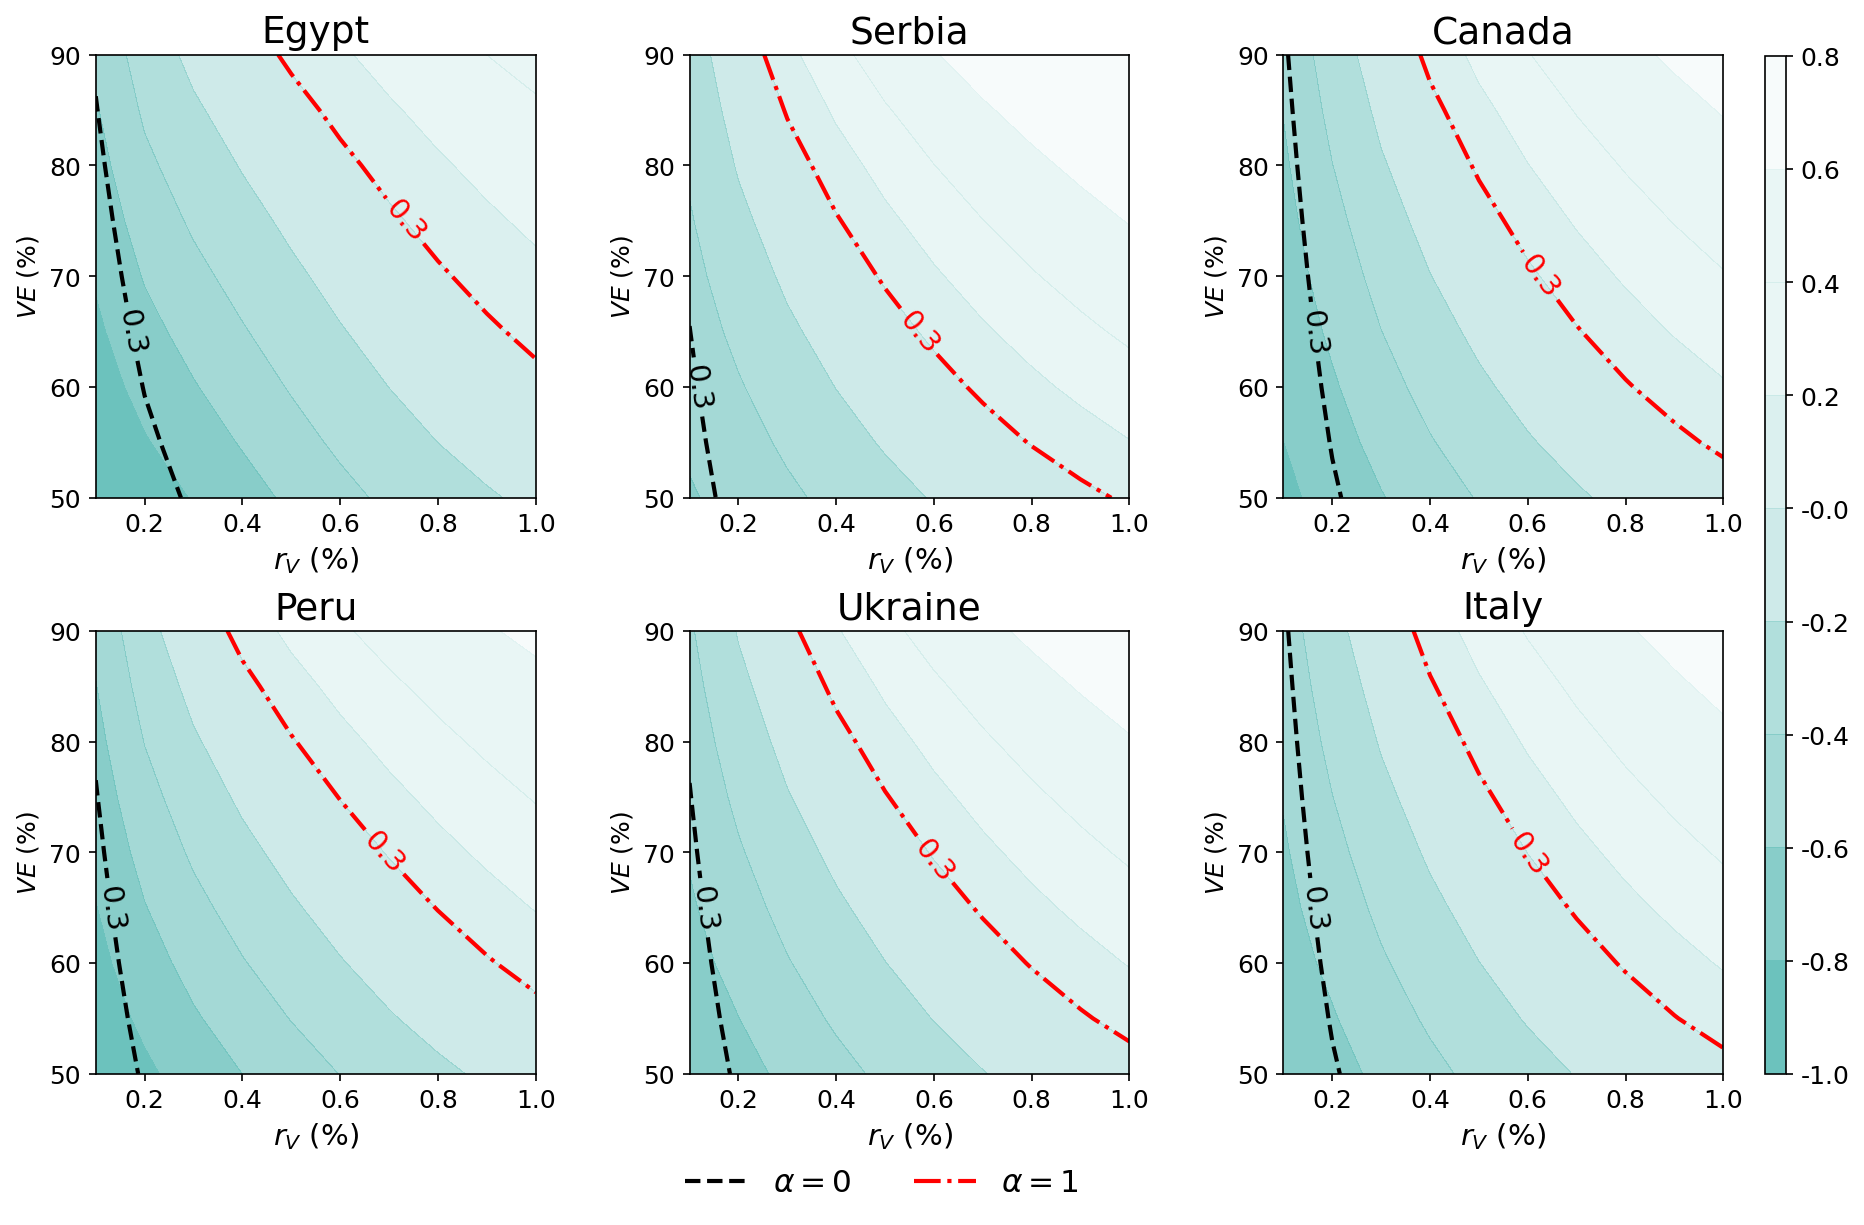

In [5]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import to_rgba

import pickle as pkl
with open("../output/VE_vs_rV_alpha1.pkl", "rb") as file: 
    data = pkl.load(file)   
    
with open("../output/VE_vs_rV_alpha1_nobe.pkl", "rb") as file: 
    data_nobe = pkl.load(file)   

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
colors = ['#6CC2BD', '#5A809E', '#7C79A2', '#F57D7C', '#FFC1A6', '#FEE4C4']
countries  = ["Egypt", "Serbia", "Canada", "Peru", "Ukraine", "Italy"]
cmap = LinearSegmentedColormap.from_list('mycmap', ["white", colors[1]])

c=0
cmap_colors = [to_rgba(colors[c], alpha=i) for i in np.linspace(0.05, 1, 11)]
cmap_colors.reverse()
cmap = ListedColormap(cmap_colors)


X, Y = np.meshgrid(100 * np.array(rVs), 100 * np.array(VEs))

vmin, vmax = 100, 0
for country in countries:
    for strategy in vaccination_strategies:
        if data[country][strategy].min() < vmin: 
            vmin = data[country][strategy].min()
        if data[country][strategy].max() > vmax:
            vmax = data[country][strategy].max()

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14,9), dpi=150)
i, j = 0, 0
levels = np.concatenate((np.linspace(vmin, 0.3, 6), np.linspace(0.3, vmax, 5)[1:]))

for country in countries:
    
    im = axes[i, j].contourf(X, Y, data[country]["old_first"], origin="lower", interpolation="gaussian", levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)
    CS1 = axes[i, j].contour(X, Y, data[country]["old_first"], origin="lower", levels = [0.3,], colors=("red",),linestyles=('-.',),linewidths=(2,))
    CS2 = axes[i, j].contour(X, Y, data_nobe[country]["old_first"], origin="lower", levels = [0.3,], colors=("k",),linestyles=('--',),linewidths=(2,))
    p1 = axes[i,j].clabel(CS1, fmt = '%.1f', colors = 'red', fontsize=14) #contour line labels
    axes[i,j].clabel(CS2, fmt = '%.1f', colors = 'k', fontsize=14) #contour line labels
    axes[i, j].set_title(country, fontsize=18)
    axes[i,j].tick_params(axis="both", labelsize=12)
    
    axes[i, j].set_xlabel("$r_V$ (%)",  fontsize=14)
    axes[i, j].set_ylabel("$VE$ (%)",  fontsize=12)
 
    j += 1
    if j == 3:
        j = 0
        i += 1
    
cbar_vaccine_ax = fig.add_axes([0.92, 0.125, 0.01, 0.754])
cbar_vaccine = plt.colorbar(im, cax=cbar_vaccine_ax)
cbar_vaccine.ax.tick_params(labelsize=12) 
cbar_vaccine.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color="k", lw=2, linestyle="--"), 
           Line2D([0], [0], color="red", lw=2, linestyle="-.")]
labels  = ["$\\alpha=0$", "$\\alpha=1$"]
axes[1,2].legend(handles, labels, ncol=2, bbox_to_anchor=[-0.4,-0.15,0,0], fontsize=15, frameon=False)
plt.subplots_adjust(hspace=0.3, wspace=0.35)

plt.savefig("./img/VE_vs_rV.pdf", bbox_inches="tight")